### Data Exploration: Bootstrap Confidence Interval & Example AB Test

Introduction: The bootstrap is a general tool that can be used to generate confidence intervals for most statistics, or model parameters. 
This script: 
* reads a sample 'flights' dataset
* create bootstrap samples of mean & confidence interval from 1) scratch, &  2) using scipy's bootstrap package
* example AB permutation test (equivalent of chi-sq)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
np.__version__

'1.21.6'

In [3]:
import scipy.stats
import scipy
scipy.__version__

'1.7.3'

#### read flight dataset

source: https://www.kaggle.com/competitions/flight-delays-spring-2018/data?select=flight_delays_train.csv

In [4]:
flight_df = pd.read_csv('flight_delays_train.csv')

In [5]:
flight_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [6]:
flight_df.describe()

,DepTime,Distance
count,100000.000000,100000.00000
mean,1341.523880,729.39716
std,476.378445,574.61686
min,1.000000,30.00000
25%,931.000000,317.00000
50%,1330.000000,575.00000
75%,1733.000000,957.00000
max,2534.000000,4962.00000


### 1) bootstrap (from scratch)

#### create bootstrap function (i.e. random sample)

In [7]:
def generate_bootstrap(data,func):
    """Generate bootstrap replicate of 1 dimensional data. I.e Create a random sample with replacement and apply function"""
    bootstrap_sample = np.random.choice(data,len(data),replace=True)
    return func(bootstrap_sample)

In [8]:
# test the boostrap replication function
generate_bootstrap(flight_df.Distance, np.mean)

728.37142

#### replicate the bootstrap

In [9]:
def replicate_bootstrap(data, func, size=10000):
    """Generate size bootstrap samples"""
    bootstrap_replicates = []
    for i in range(size):
        result = generate_bootstrap(data, func)
        bootstrap_replicates.append(result)
    return bootstrap_replicates

In [10]:
%%timeit
bootstrap_replicates = replicate_bootstrap(flight_df.Distance, np.mean,size=1000)

1.36 s ± 6.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### calculate a two-sided confidence interval

In [11]:
bootstrap_replicates= replicate_bootstrap(flight_df.Distance, np.mean,size=1000)

In [12]:
conf_int = np.percentile(bootstrap_replicates, [2.5,97.5])
print(conf_int)

[725.9556935  732.89132275]


#### plot histogram of bootstrap replicates of confidence interval around the mean

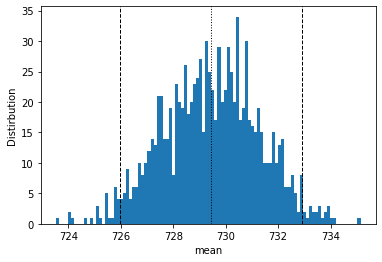

In [13]:
plt.hist(bootstrap_replicates, bins=100)
plt.xlabel('mean')
plt.ylabel('Distirbution')
plt.axvline(conf_int[0], color='k', linestyle='dashed', linewidth=1)
plt.axvline(conf_int[1], color='k', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(bootstrap_replicates), color='k', linestyle='dotted', linewidth=1)
plt.show()

### 2) Comparison to Scipy implementation of bootstrap

In [14]:
### https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html
# default sample size is 9999

In [15]:
from scipy.stats import bootstrap

In [16]:
rng = np.random.default_rng()
rng

Generator(PCG64) at 0x7F9D75CCE8C0

In [17]:
%%timeit
# convert data to a sequence
res = bootstrap((flight_df.Distance,),n_resamples=1000,method='percentile', statistic=np.mean, confidence_level=0.95,random_state=rng)

1.1 s ± 7.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
res = bootstrap((flight_df.Distance,),n_resamples=1000,method='percentile', statistic=np.mean, confidence_level=0.95,random_state=rng)

In [19]:
print(res.confidence_interval)

ConfidenceInterval(low=725.9343435000001, high=733.22113425)


### Worked Example: AB permutation test

In [65]:
# source: https://github.com/just4jc/DataCamp-3/tree/master/07-statistical-thinking-in-python-(part-2)

In [66]:
# clickthrough_A, clickthorugh_B: array of 1s and 0s

In [68]:
clickthrough_A = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0]
clickthrough_B = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0]

#### function to compare mean clickthrough rates

In [69]:
def diff_frac(data_A,data_B):
    frac_A = np.sum(data_A) / len(data_A)
    frac_B = np.sum(data_B) / len(data_B)
    return frac_B - frac_A

In [70]:
diff_frac_obs = diff_frac(clickthrough_A,clickthrough_B)

In [71]:
diff_frac_obs

0.026915113871635615

#### create permutation test of click throughdef permutation_sample(data1, data2):

In [72]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [73]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

In [74]:
perm_replicates = draw_perm_reps(clickthrough_A, clickthrough_B, diff_frac,size=10000)

In [75]:
p_value = np.sum(perm_replicates > diff_frac_obs)/ 10000
p_value

0.2764

In [ ]:
i.e. expect to see this one-sided test 27.6% of the time